In [36]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from joblib import dump
from joblib import load

### 1) Load yerevan_houses.csv dataset. The target variable is the Price (don't separate the label at first).

In [37]:
df = pd.read_csv("/home/artur/Desktop/yerevan_houses.csv")
df

,Unnamed: 0.1,Unnamed: 0,price,condition,district,max_floor,street,num_rooms,region,area,url,num_bathrooms,building_type,floor,ceiling_height
0,4822,5262,75000.0,good,Center,4,Buzand St,3,Yerevan,105.0,http://www.myrealty.am/en/item/29314/3-senyaka...,1,stone,4,3.2
1,4893,5340,110000.0,newly repaired,Davtashen,15,Mikoyan St,4,Yerevan,114.0,http://www.myrealty.am/en/item/28191/4-senyaka...,2,monolit,9,3.2
2,3920,4312,57000.0,newly repaired,Shengavit,5,Arshakunyats Ave,2,Yerevan,82.0,http://www.myrealty.am/en/item/15897/2-senyaka...,1,stone,2,3.2
3,4465,4889,49000.0,newly repaired,Qanaqer-Zeytun,9,Gogol St,1,Yerevan,78.0,http://www.myrealty.am/en/item/26114/1-senyaka...,1,other,9,2.8
4,1760,2030,125000.0,newly repaired,Arabkir,10,A. Avetisyan St,3,Yerevan,140.0,http://www.myrealty.am/en/item/13331/Apartment...,1,panel,10,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5169,1060,1288,158000.0,newly repaired,Center,8,Buzand St,3,Yerevan,73.0,http://www.myrealty.am/en/item/31115/3-senyaka...,1,monolit,2,3.0
5170,2585,2904,58000.0,good,Arabkir,14,Hakobyan St,3,Yerevan,84.0,http://www.myrealty.am/en/item/11055/apartment...,1,panel,13,2.8
5171,5823,6339,87000.0,good,Arabkir,9,A. Khachatrian St,3,Yerevan,100.0,http://www.myrealty.am/en/item/29095/3-senyaka...,1,panel,9,2.8
5172,5797,6313,47000.0,good,Arabkir,5,Komitas Ave,2,Yerevan,51.0,http://www.myrealty.am/en/item/14137/2-senyaka...,1,other,1,2.8


### 2) Find and remove the columns that clearly don't help.

In [38]:
columns_to_drop = ["Unnamed: 0.1", "Unnamed: 0", "region", "url"]
for col in columns_to_drop:
    df = df.drop(col, axis = 1)
df

,price,condition,district,max_floor,street,num_rooms,area,num_bathrooms,building_type,floor,ceiling_height
0,75000.0,good,Center,4,Buzand St,3,105.0,1,stone,4,3.2
1,110000.0,newly repaired,Davtashen,15,Mikoyan St,4,114.0,2,monolit,9,3.2
2,57000.0,newly repaired,Shengavit,5,Arshakunyats Ave,2,82.0,1,stone,2,3.2
3,49000.0,newly repaired,Qanaqer-Zeytun,9,Gogol St,1,78.0,1,other,9,2.8
4,125000.0,newly repaired,Arabkir,10,A. Avetisyan St,3,140.0,1,panel,10,3.0
...,...,...,...,...,...,...,...,...,...,...,...
5169,158000.0,newly repaired,Center,8,Buzand St,3,73.0,1,monolit,2,3.0
5170,58000.0,good,Arabkir,14,Hakobyan St,3,84.0,1,panel,13,2.8
5171,87000.0,good,Arabkir,9,A. Khachatrian St,3,100.0,1,panel,9,2.8
5172,47000.0,good,Arabkir,5,Komitas Ave,2,51.0,1,other,1,2.8


### 3) Find the correlations between the columns

In [39]:
numerical_columns = df.select_dtypes(include=["float64", "int64"])
correlation_matrix = numerical_columns.corr()
correlation_matrix

,price,max_floor,num_rooms,area,num_bathrooms,floor,ceiling_height
price,1.000000,0.104160,0.348904,0.625097,0.438676,0.074210,0.372886
max_floor,0.104160,1.000000,0.044871,0.154012,0.108997,0.638557,-0.038240
num_rooms,0.348904,0.044871,1.000000,0.751205,0.276119,0.045906,0.079352
area,0.625097,0.154012,0.751205,1.000000,0.417058,0.105497,0.210159
num_bathrooms,0.438676,0.108997,0.276119,0.417058,1.000000,0.060989,0.225909
floor,0.074210,0.638557,0.045906,0.105497,0.060989,1.000000,-0.024597
ceiling_height,0.372886,-0.038240,0.079352,0.210159,0.225909,-0.024597,1.000000


### 4) Find unique values and their counts in necessary columns.

In [40]:
unique_value_counts = {}
for col in df:
    unique_value_counts[col] = df[col].value_counts()
unique_value_counts

{'price': price
 65000.0     145
 60000.0     137
 45000.0     134
 50000.0     130
 75000.0     125
            ... 
 310000.0      1
 51600.0       1
 198900.0      1
 51500.0       1
 37700.0       1
 Name: count, Length: 338, dtype: int64,
 'condition': condition
 newly repaired    3008
 good              1739
 zero condition     427
 Name: count, dtype: int64,
 'district': district
 Center              2153
 Arabkir             1354
 Avan                 269
 Davtashen            258
 Nor Norq             243
 Malatia-Sebastia     227
 Achapnyak            210
 Qanaqer-Zeytun       195
 Shengavit            176
 Erebuni               80
 Norq Marash            5
 Vahagni district       3
 Nubarashen             1
 Name: count, dtype: int64,
 'max_floor': max_floor
 5     1371
 9     1040
 4      519
 14     472
 10     316
 16     276
 12     209
 11     166
 6      163
 7      136
 13     109
 15      86
 3       69
 8       61
 17      51
 18      45
 22      16
 21      16
 19 

### 5) Use plots, scatterplots, histograms, boxplots, etc. to visualize the relationships of different columns to price. (Hint: When prices are compared to categorical columns, they should be grouped by the columns' unique values (e.g. df.groupby('num_bathrooms').price.mean())).

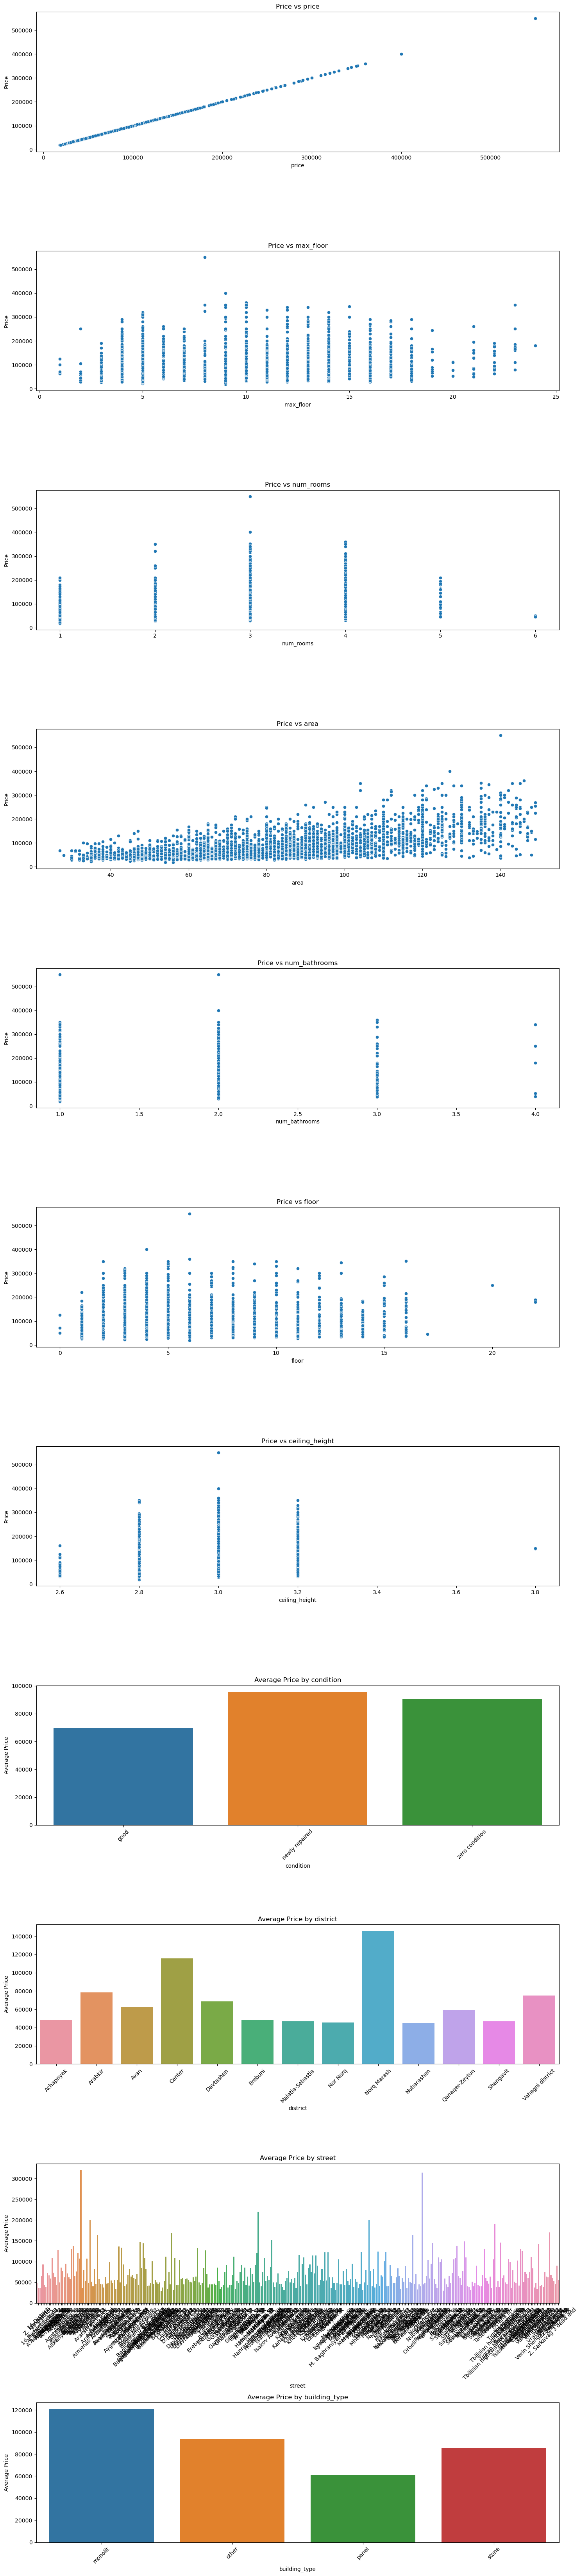

In [41]:
def plot_price_dependence(dataframe, numerical_col_names, categorical_col_names):
    num_numerical_cols = len(numerical_col_names)
    num_categorical_cols = len(categorical_col_names)
    total_cols = num_numerical_cols + num_categorical_cols
    
    fig, axes = plt.subplots(total_cols, 1, figsize=(15, 6 * total_cols))

    # Plot for each numerical column
    for i, col in enumerate(numerical_col_names):
        ax = axes[i]
        sns.scatterplot(data=dataframe, x=col, y='price', ax=ax)
        ax.set_title(f'Price vs {col}')
        ax.set_ylabel('Price')
        ax.set_xlabel(col)

    # Plot for each categorical column
    for j, col in enumerate(categorical_col_names):
        ax = axes[num_numerical_cols + j]
        grouped_data = dataframe.groupby(col)['price'].mean().reset_index()
        sns.barplot(data=grouped_data, x=col, y='price', ax=ax)
        ax.set_title(f'Average Price by {col}')
        ax.set_ylabel('Average Price')
        ax.set_xlabel(col)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Get column names for numerical and categorical data
numerical_col_names = df.select_dtypes(include=["float64", "int64"]).columns
categorical_col_names = df.select_dtypes(include=["object"]).columns

# Call the function
plot_price_dependence(df, numerical_col_names, categorical_col_names)


### 6) Clear the data. Remove the least "correlated" columns.

In [42]:
threshold = 0.1
low_corr_cols = correlation_matrix['price'][abs(correlation_matrix['price']) < threshold].index
df.drop(columns=low_corr_cols,inplace=True)
df


,price,condition,district,max_floor,street,num_rooms,area,num_bathrooms,building_type,ceiling_height
0,75000.0,good,Center,4,Buzand St,3,105.0,1,stone,3.2
1,110000.0,newly repaired,Davtashen,15,Mikoyan St,4,114.0,2,monolit,3.2
2,57000.0,newly repaired,Shengavit,5,Arshakunyats Ave,2,82.0,1,stone,3.2
3,49000.0,newly repaired,Qanaqer-Zeytun,9,Gogol St,1,78.0,1,other,2.8
4,125000.0,newly repaired,Arabkir,10,A. Avetisyan St,3,140.0,1,panel,3.0
...,...,...,...,...,...,...,...,...,...,...
5169,158000.0,newly repaired,Center,8,Buzand St,3,73.0,1,monolit,3.0
5170,58000.0,good,Arabkir,14,Hakobyan St,3,84.0,1,panel,2.8
5171,87000.0,good,Arabkir,9,A. Khachatrian St,3,100.0,1,panel,2.8
5172,47000.0,good,Arabkir,5,Komitas Ave,2,51.0,1,other,2.8


### 7) Find and remove the outliers

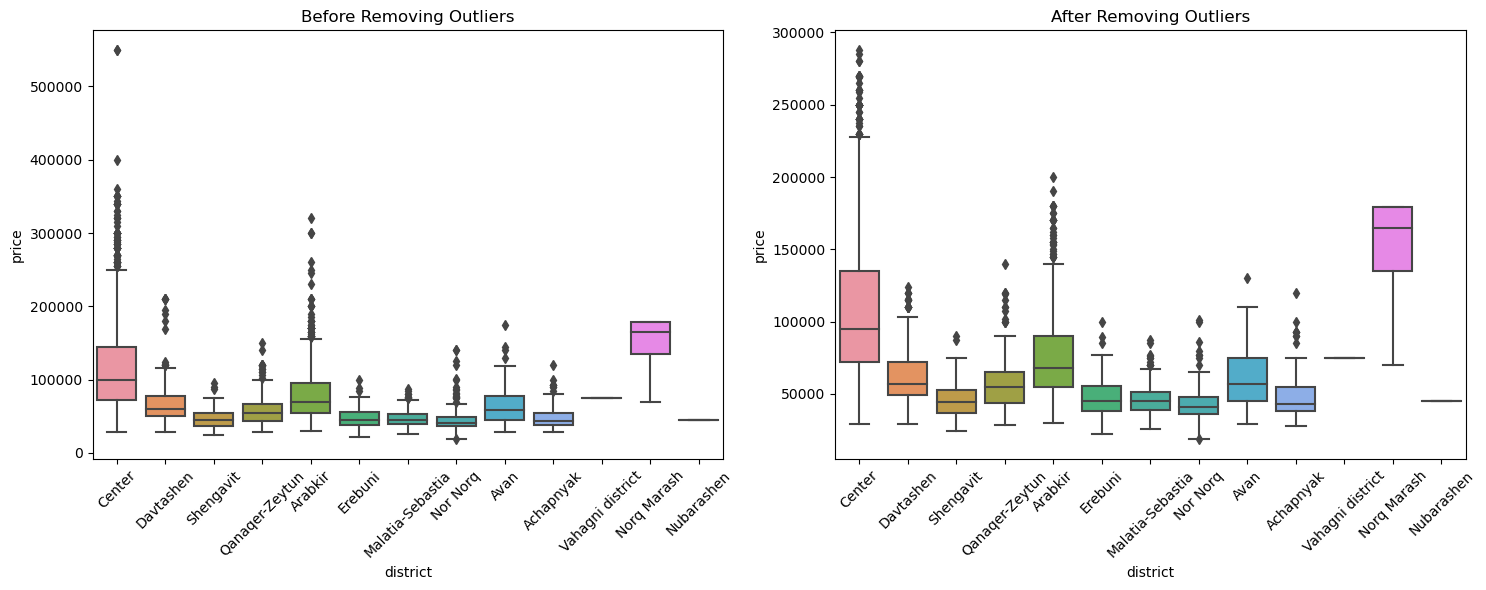

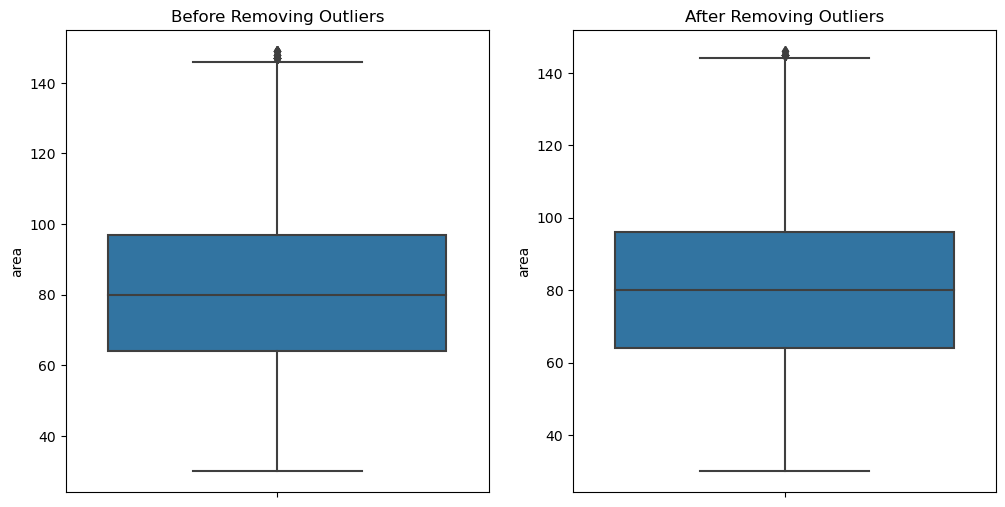

In [43]:
def calculate_price_per_unit(df):
    df["price_per_unit_area"] = df["price"] / df["area"]
    avg_price_per_unit_area = df.groupby("district")["price_per_unit_area"].mean()
    return avg_price_per_unit_area

avg_price_per_unit_area = calculate_price_per_unit(df)

def remove_outliers(df, avg_price_per_unit_area):
    df = df.join(avg_price_per_unit_area, on='district', rsuffix='_avg')
    df['expected_price'] = df['area'] * df['price_per_unit_area_avg']
    threshold = 0.5
    df_filtered = df[(df['price'] >= (1 - threshold) * df['expected_price']) & (df['price'] <= (1 + threshold) * df['expected_price'])]

    return df_filtered

df_no_outliers = remove_outliers(df, avg_price_per_unit_area)
# df_no_outliers
plt.figure(figsize=(15, 6))

# Boxplot before removing outliers
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='district', y='price')
plt.title('Before Removing Outliers')
plt.xticks(rotation=45)

# Boxplot after removing outliers
plt.subplot(1, 2, 2)
sns.boxplot(data=df_no_outliers, x='district', y='price')
plt.title('After Removing Outliers')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

df = df_no_outliers
ceiling_height_outlier = df[df["ceiling_height"] > 3.2].index
num_of_bathroom_outlier = df[df["num_bathrooms"] >= 3].index
df = df.drop(ceiling_height_outlier)
df = df.drop(num_of_bathroom_outlier)

def remove_area_outliers(df, column_name='area'):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_filtered

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='area')
plt.title('Before Removing Outliers')
df_no_area_outliers = remove_area_outliers(df, 'area')
plt.subplot(1, 2, 2)
sns.boxplot(data=df_no_area_outliers, y='area')
plt.title('After Removing Outliers')
plt.show()

df = df_no_area_outliers


### 8) Separate the feature and target variables into X and y.

In [44]:
y = df["price"]
columns_to_drop = ["price", "price_per_unit_area", "price_per_unit_area_avg", "expected_price"]
x = df.drop(columns_to_drop,axis=1)
x

,condition,district,max_floor,street,num_rooms,area,num_bathrooms,building_type,ceiling_height
0,good,Center,4,Buzand St,3,105.0,1,stone,3.2
1,newly repaired,Davtashen,15,Mikoyan St,4,114.0,2,monolit,3.2
2,newly repaired,Shengavit,5,Arshakunyats Ave,2,82.0,1,stone,3.2
3,newly repaired,Qanaqer-Zeytun,9,Gogol St,1,78.0,1,other,2.8
4,newly repaired,Arabkir,10,A. Avetisyan St,3,140.0,1,panel,3.0
...,...,...,...,...,...,...,...,...,...
5168,newly repaired,Davtashen,11,Davtashen 4 district,3,81.0,1,monolit,2.8
5170,good,Arabkir,14,Hakobyan St,3,84.0,1,panel,2.8
5171,good,Arabkir,9,A. Khachatrian St,3,100.0,1,panel,2.8
5172,good,Arabkir,5,Komitas Ave,2,51.0,1,other,2.8


### 9) Scale, One Hot Encode the columns (Also try to achieve overfitting by increasing the amount of features)

In [45]:
columns_to_drop = ["price_per_unit_area", "price_per_unit_area_avg", "expected_price"]
df = df.drop(columns_to_drop, axis=1)

from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include=['object']).columns
def encoding(df):
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

def min_max_scaler(data):
    for col in df.columns:
            min_value = data[col].min()
            max_value = data[col].max()
            data[col] = (data[col] - min_value) / (max_value - min_value)
    return data
encoding(df)
df = min_max_scaler(df)
df

,price,condition,district,max_floor,street,num_rooms,area,num_bathrooms,building_type,ceiling_height
0,0.212008,0.0,0.250000,0.130435,0.258065,0.4,0.646552,0.0,1.000000,1.000000
1,0.343340,0.5,0.333333,0.608696,0.645161,0.6,0.724138,1.0,0.000000,1.000000
2,0.144465,0.5,0.916667,0.173913,0.117302,0.2,0.448276,0.0,1.000000,1.000000
3,0.114447,0.5,0.833333,0.347826,0.384164,0.0,0.413793,0.0,0.333333,0.333333
4,0.399625,0.5,0.083333,0.391304,0.011730,0.4,0.948276,0.0,0.666667,0.666667
...,...,...,...,...,...,...,...,...,...,...
5168,0.136961,0.5,0.333333,0.434783,0.304985,0.4,0.439655,0.0,0.000000,0.333333
5170,0.148218,0.0,0.083333,0.565217,0.410557,0.4,0.465517,0.0,0.666667,0.333333
5171,0.257036,0.0,0.083333,0.347826,0.020528,0.4,0.603448,0.0,0.666667,0.333333
5172,0.106942,0.0,0.083333,0.173913,0.524927,0.2,0.181034,0.0,0.333333,0.333333


## Model

### 11) Use linear, ridge, and lasso regressions in combination with K-Fold CV to fit your training data. Calculate RMSE, MSE, MAE, and R-Squared for each split. Visualize the results.

In [46]:
y = df['price']
X = df.drop('price', axis=1)  

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
metrics = {"Linear": {"MSE": [], "MAE": [], "R2": []},
           "Ridge": {"MSE": [], "MAE": [], "R2": []},
           "Lasso": {"MSE": [], "MAE": [], "R2": []}}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for name, model in zip(["Linear", "Ridge", "Lasso"], [LinearRegression(), Ridge(alpha=1.0), Lasso(alpha=0.001)]):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        metrics[name]["MSE"].append(mse)
        metrics[name]["MAE"].append(mae)
        metrics[name]["R2"].append(r2)

for model in metrics:
    print(f"{model} - Average MSE: {np.mean(metrics[model]['MSE'])}")
    print(f"{model} - Average MAE: {np.mean(metrics[model]['MAE'])}")
    print(f"{model} - Average R2: {np.mean(metrics[model]['R2'])}")


Linear - Average MSE: 0.011041341253991864
Linear - Average MAE: 0.07853285202295965
Linear - Average R2: 0.5574628357793495
Ridge - Average MSE: 0.01104340937423662
Ridge - Average MAE: 0.07849392791309114
Ridge - Average R2: 0.5574006712001446
Lasso - Average MSE: 0.011387040762787532
Lasso - Average MAE: 0.07969207648154276
Lasso - Average R2: 0.5438096788446107


### 12) After finding the best model (linear/ridge/lasso and hyperparameters) train the model on the whole data and save the weights.

In [47]:
best_model = Ridge(alpha=1.0)
best_model.fit(X, y)
dump(best_model, '/home/artur/Desktop/best_model.joblib')

coefficents = best_model.coef_
intercept = best_model.intercept_
print(coefficents, intercept)

[ 0.01559281 -0.09344819 -0.07099181  0.01428231 -0.1703477   0.5390551
  0.06194636 -0.03433421  0.11686608] 0.04507923313868345


## Testing

### 13) Load test_data.csv

In [48]:
test_file = "/home/artur/Desktop/test_data.csv"
test_df = pd.read_csv(test_file)
test_df

,Unnamed: 0.1,Unnamed: 0,price,condition,district,max_floor,street,num_rooms,region,area,url,num_bathrooms,building_type,floor,ceiling_height
0,2,2,97000.0,newly repaired,Center,10,Teryan St,2,Yerevan,72.0,http://www.myrealty.am/en/item/29472/2-senyaka...,1,panel,3,2.8
1,17,20,115000.0,newly repaired,Arabkir,10,Hambardzumyan St,3,Yerevan,69.0,http://www.myrealty.am/en/item/15367/3-senyaka...,1,monolit,7,3.0
2,37,50,110000.0,newly repaired,Center,14,Agatangeghos St,3,Yerevan,90.0,http://www.myrealty.am/en/item/20358/3-senyaka...,1,panel,5,3.0
3,48,66,120000.0,good,Center,5,A.Manukyan St,4,Yerevan,100.0,http://www.myrealty.am/en/item/25293/4-senyaka...,1,stone,2,3.0
4,57,77,43000.0,good,Arabkir,5,Komitas Ave,1,Yerevan,35.0,http://www.myrealty.am/en/item/6934/1-senyakan...,1,stone,4,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,6203,6781,35000.0,good,Nor Norq,12,Lvovyan St,2,Yerevan,56.0,http://www.myrealty.am/en/item/33995/2-senyaka...,1,panel,1,2.8
1056,6208,6786,35000.0,newly repaired,Achapnyak,4,Halabyan St,1,Yerevan,40.0,http://www.myrealty.am/en/item/20160/1-senyaka...,1,stone,1,2.6
1057,6214,6792,35000.0,good,Malatia-Sebastia,9,Gusan Sheram St,3,Yerevan,83.0,http://www.myrealty.am/en/item/36136/3-senyaka...,1,panel,6,2.8
1058,6217,6795,35000.0,good,Nor Norq,9,Norq 7 p,3,Yerevan,73.0,http://www.myrealty.am/en/item/36061/3-senyaka...,1,panel,1,2.8


### 14) Preprocess the testing data using the same steps you used for training data

In [49]:
columns_to_drop = ["Unnamed: 0.1", "Unnamed: 0", "region", "url","floor"]
test_df.drop(columns_to_drop, axis=1, inplace=True)

categorical_cols = test_df.select_dtypes(include=['object']).columns
encoding(test_df)
test_df = min_max_scaler(test_df)
test_df



         price  condition  district  max_floor    street  num_rooms      area  \
27    0.169329        0.5  0.333333   0.363636  0.937198       0.50  0.516667   
29    0.376997        0.5  0.888889   0.363636  0.801932       0.75  0.891667   
32    0.242812        1.0  0.111111   0.454545  0.536232       0.75  0.666667   
33    0.230032        0.5  0.111111   0.681818  0.057971       0.50  0.558333   
37    0.230032        0.5  0.333333   0.590909  0.130435       0.50  0.625000   
...        ...        ...       ...        ...       ...        ...       ...   
1044  0.568690        0.5  0.333333   0.318182  0.917874       0.75  0.941667   
1046  0.565495        0.5  0.333333   0.136364  0.768116       0.75  0.933333   
1047  0.552716        0.5  0.333333   0.272727  0.951691       0.50  0.816667   
1049  0.552716        0.5  0.111111   0.590909  0.661836       0.75  0.850000   
1052  0.025559        0.0  0.666667   0.045455  0.811594       0.75  0.791667   

      num_bathrooms  buildi

### 15) Load the saved model into a new variable and evaluate it.

In [52]:
loaded_model = load('/home/artur/Desktop/best_model.joblib')
x_test = test_df.select_dtypes(include=[np.number]).drop('price', axis=1)
y_pred_test = loaded_model.predict(x_test)
y_pred_test


array([0.15682735, 0.15734278, 0.19007733, ..., 0.12096624, 0.07014664,
       0.09597814])

### 16) Compare your results for training and testing sets and interprete your results.

In [53]:

test_df['predicted_price'] = y_pred_test
y_test = test_df['price']
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
rmse = math.sqrt(mse)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")



MSE: 0.013364365180373155
MAE: 0.08163505529148121
RMSE: 0.11560434758422002
R-squared: 0.4864223642173755
